<a href="https://colab.research.google.com/github/ivkarla/connectivity_change/blob/main/notebooks/fixedL_transition_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook analyzes the connectivity change results from the seizure transition time frame of fixed length (L). This code generated the plots from Figure 3.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind, shapiro, mannwhitneyu

from google.colab import drive
drive.mount('/content/gdrive')
main_folder = "/content/gdrive/Shared drives/A&K/data/"

Mounted at /content/gdrive


Seizure lengths for all patients extracted from metadata:

In [2]:
lens = [138.94799999999998,
118.67600000000004,
81.62799999999993,
84.98400000000004,
93.65200000000004,
34.485839899999974,
91.15200000000004,
74.02200000000005,
357.606,
100.97800000000007,
221.58999999999992,
83.37,
92.26799999999992,
13.990000000000009,
108.10200000000009,
24.583999999999946,
505.45799999999997,
153.08105469999998,
20.696000000000026,
80.78710940000008,
24.583984399999963]

Plot seizure lengths:

Interquartile range: 74.02200000000005 118.67600000000004
Sigma = 114.20745952652496


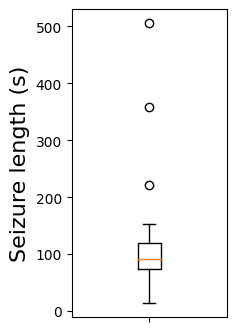

In [6]:
x=np.array(lens)

q1_x = np.percentile(x, 25, interpolation='midpoint')
q3_x = np.percentile(x, 75, interpolation='midpoint')

print("Interquartile range:", q1_x, q3_x)
print("Sigma =", np.std(x))

# Plot seizure lengths
# plt.hist(list(lens.values()), bins=21, histtype='stepfilled', color="grey")
plt.figure(figsize=(2,4))
plt.boxplot(x)
plt.ylabel("Seizure length (s)", size=16)
plt.xticks([1], [""], size=16)
plt.show()

Plot AUC distribution for fixed vs. relative time interval and check if there is a significant difference:

<ipython-input-24-959b003798f0>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp=sns.boxplot(y="auc", x="tick", data=data, palette="colorblind", width=0.3, medianprops=dict(color="black", alpha=0.9))


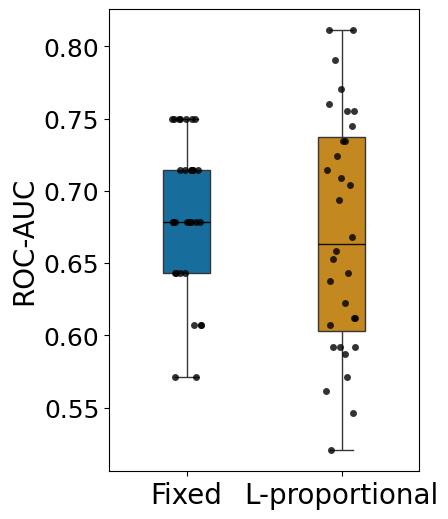

MannwhitneyuResult(statistic=560.0, pvalue=0.522508774668554)


In [24]:
fixed = pd.read_excel(main_folder + "AUC/AUC_percentage_NSfixed27.xlsx")
relative = pd.read_excel(main_folder + "1cm_rocauc_results.xlsx")

relative = relative[relative["WOI"]=="NS"]

# Plot AUC distribution for fixed vs. relative time interval
fauc = list(fixed["AUC"])
rauc = list(relative["AUC"])
ticks = ["FIXED"]*len(fauc)+["RELATIVE"]*len(rauc)

data = {"auc":fauc+rauc,"tick":ticks}

plt.figure(figsize=(4, 6))

bp=sns.boxplot(y="auc", x="tick", data=data, palette="colorblind", width=0.3, medianprops=dict(color="black", alpha=0.9))
bp=sns.stripplot(y="auc", x="tick", data=data, jitter=True, dodge=True, marker="o", alpha=0.8, color="black")

plt.ylabel("ROC-AUC", size=20)
plt.xlabel("")
plt.yticks(fontsize=18)
plt.xticks([0,1], ["Fixed", "L-proportional"], fontsize=20)
plt.show()

# P value
t=0
if shapiro(fauc)[1]<0.05 and shapiro(rauc)[1]<0.05:
    t=ttest_ind(fauc,rauc)
else:
    t=mannwhitneyu(fauc,rauc,alternative="two-sided")
print(t)


Change in surgery outcome prediction ROC-AUC per individual analysis when considering L-proportional time window analysis relative to the fixed window analysis.

In [25]:
import re

# Dictionary for band symbol substitutions
band_subs = {
    "1,4": "δ",
    "4,8": "ϴ",
    "8,12": "α",
    "13,30": "β",
    "30,70": "low γ",
    "70,150": "high γ"
}

# Dictionary for connectivity method substitutions
cm_subs = {
    "SC_R": "Real spectral coherence",
    "SC_I": "Imaginary spectral coherence",
    "PLV": "Phase-locking value",
    "PLI": "Phase lag index",
    "CC": "Cross-correlation",
    "PAC": "PAC",
    "PEC": "PEC"
}

# Function to replace bands with their corresponding symbols
def substitute_bands(s):
    # Find all occurrences of band ranges in the format "(a,b)"
    bands = re.findall(r'\(\d+,\d+\)', s)

    # Substitute each band range with its corresponding symbol
    for band in bands:
        band_range = band[1:-1]  # Remove parentheses
        if band_range in band_subs:
            s = s.replace(band, f" ({band_subs[band_range]})")

    return s

# Function to replace connectivity methods with their corresponding names
def substitute_cm(s):
    # Find all occurrences of connectivity method prefixes
    for cm in cm_subs:
        s = re.sub(r'\b' + cm + r'\b', cm_subs[cm], s)

    return s


0.2193877551020409


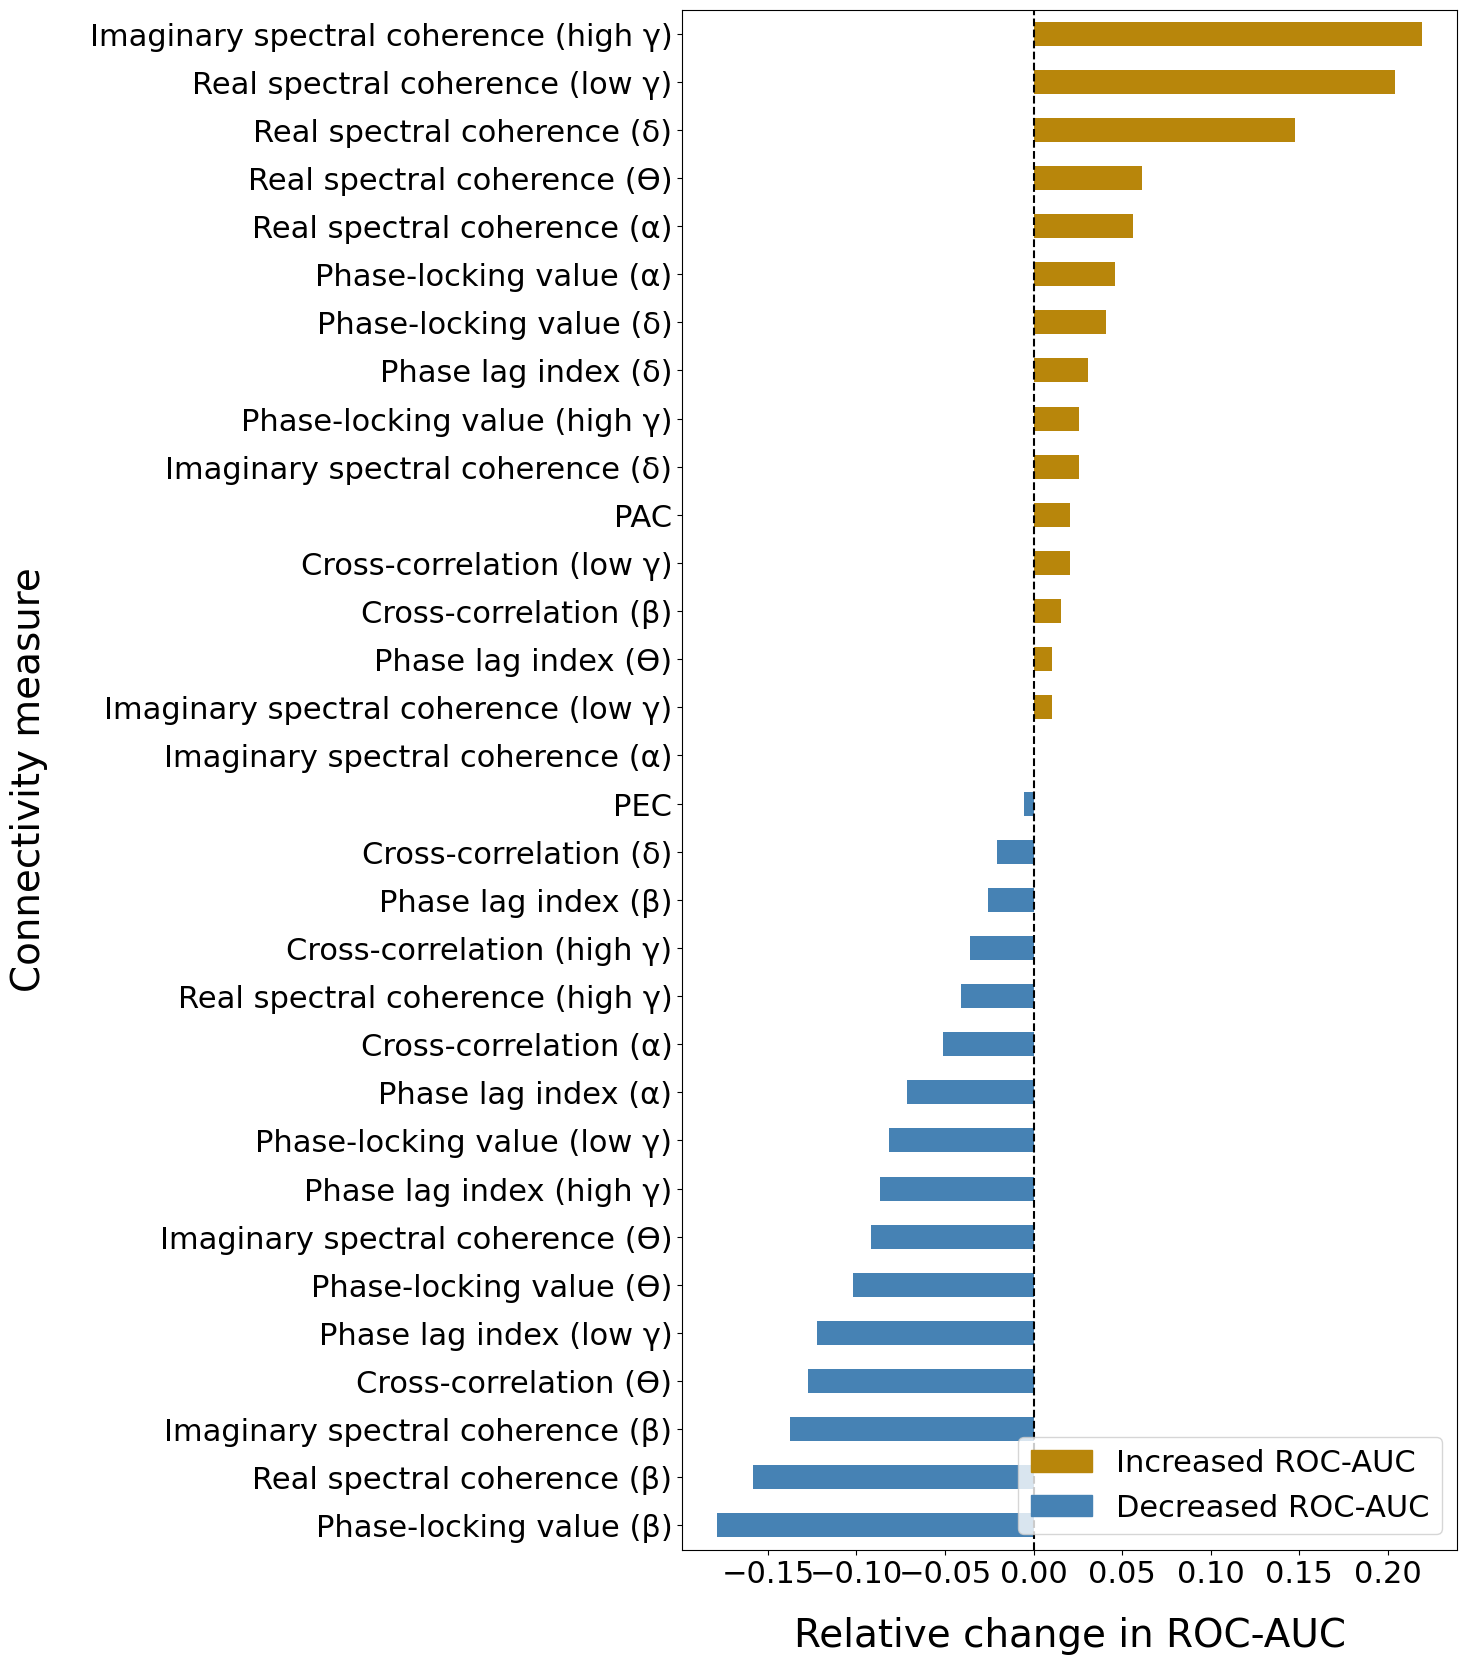

In [27]:
methods =list(fixed["Connectivity method"])
f = dict(zip(fixed["Connectivity method"], fixed["AUC"]))
r = dict(zip(relative["CM"], relative["AUC"]))

x = {} # loss/gain in AUC per method in relative in comparison to fixed
y={}
for method in methods:

    x[substitute_bands(substitute_cm(method))]=r[method]-f[method]
    y[method]=r[method]-f[method]

print(max(x.values()))

df = pd.DataFrame.from_dict(dict(sorted(x.items(),key = lambda k:k[1])), orient ='index')

plt.figure(figsize=(10,20))

df[0].plot(kind='barh', color=(df[0] > 0).map({True: 'darkgoldenrod', False: 'steelblue'}))

import matplotlib.patches as mpatches
patch1 = mpatches.Patch(color='darkgoldenrod', label='Increased ROC-AUC')
patch2 = mpatches.Patch(color='steelblue', label='Decreased ROC-AUC', )
plt.legend(handles=[patch1,patch2], loc='lower right', fontsize=22)
plt.xticks(size=22)
plt.yticks(size=22)
plt.xlabel("Relative change in ROC-AUC", size=28, labelpad=20)
plt.ylabel("Connectivity measure", size=28, labelpad=30)
plt.axvline(x=0, ymin=0, color="black", ls="--")
plt.show()